In [1]:
!pip install tf-nightly 
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

     |████████████████████████████████| 519.0MB 30kB/s 
     |████████████████████████████████| 460kB 53.4MB/s 
     |████████████████████████████████| 3.0MB 65.9MB/s 
Tensor Flow Verion: 2.2.0-dev20200419


'/device:GPU:0'

In [3]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:23<00:00, 47.6MB/s]
100% 10.8G/10.8G [04:23<00:00, 44.2MB/s]


In [0]:
!unzip \*.zip

In [5]:
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
# from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
# import os
import cv2
from os import listdir
from os.path import isfile, join 
import re
import matplotlib.pyplot as plt
# import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16

In [0]:
train_data_dir = "OCT2017 /train"
validation_data_dir = "OCT2017 /test"

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 83484 images belonging to 4 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 968 images belonging to 4 classes.


# **CNN Model**

In [0]:
def cnn():
    model = tf.keras.models.Sequential([

    # 1st CONV-ReLU Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu",padding = 'same', input_shape = (img_rows, img_cols, 3)),
    tf.keras.layers.BatchNormalization(),

    # 2nd CONV-ReLU Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding = "same"),
    tf.keras.layers.BatchNormalization(),

    # Max Pooling with Dropout 
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    # 3rd set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu",padding="same"),
    tf.keras.layers.BatchNormalization(),

    # 4th Set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),

    # Max Pooling with Dropout 
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    # 5th Set of CONV-ReLU Layers
    tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
        
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Final Dense Layer
    tf.keras.layers.Dense(num_classes,activation="softmax"),
    ])
    return model

In [21]:
model = cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)    

# **Train CNN Model**

In [0]:
checkpoint_path = "train_ckpt/cp-{epoch:04d}.ckpt"

In [0]:
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.00001
)

callbacks=[earlystop, checkpoint, reduce_lr]

In [0]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [0]:
nb_train_samples = 83484
nb_validation_samples = 968
epochs = 10

In [19]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
5217/5217 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.8069
Epoch 00001: val_loss improved from inf to 0.21927, saving model to train_ckpt/cp-0001.ckpt
INFO:tensorflow:Assets written to: train_ckpt/cp-0001.ckpt/assets
5217/5217 [==============================] - 1149s 220ms/step - loss: 0.5357 - accuracy: 0.8069 - val_loss: 0.2193 - val_accuracy: 0.9385
Epoch 2/10
5217/5217 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8975
Epoch 00002: val_loss did not improve from 0.21927
5217/5217 [==============================] - 1015s 195ms/step - loss: 0.3001 - accuracy: 0.8975 - val_loss: 0.3461 - val_accuracy: 0.8958
Epoch 3/10
5217/5217 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9111
Epoch 00003: val_loss did not improve from 0.21927
5217/5217 [==============================] - 1016s 195ms/step - loss: 0.2597 - accuracy: 0.911

In [81]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 3s 48ms/step - loss: 0.2207 - accuracy: 0.9380

Test result: 93.802 loss: 0.221


In [20]:
!mkdir -p saved_model
model.save('saved_model/CNN5_model') 

INFO:tensorflow:Assets written to: saved_model/CNN5_model/assets


**Loading saved classifier**

In [0]:
model = tf.keras.models.load_model('saved_model/CNN5_model')

**Training and validation history**

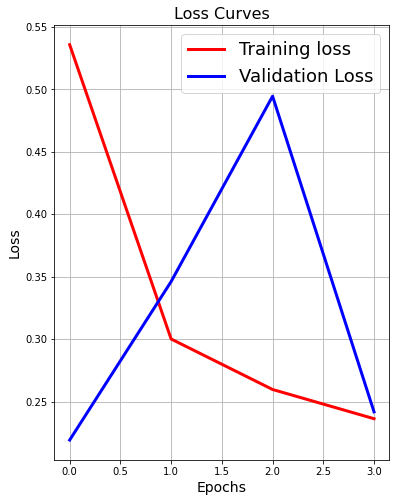

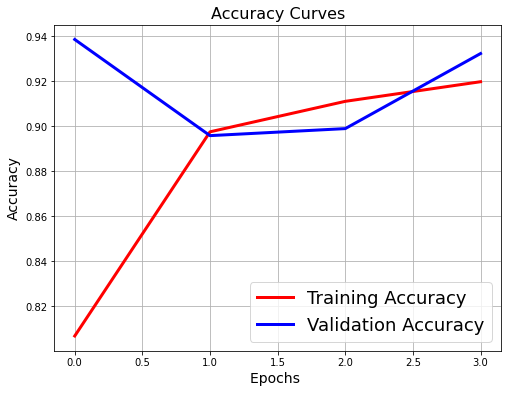

In [24]:
#Loss Curves
plt.figure(figsize=[6, 8])
plt.plot(history.history["loss"], "r", linewidth=3.0)
plt.plot(history.history["val_loss"], "b", linewidth=3.0)
plt.legend(["Training loss", "Validation Loss"], fontsize=18)
plt.grid()
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Loss Curves", fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy Curves',fontsize=16);

**Test result**

In [38]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Confusion Matrix
[[239   2   1   0]
 [ 21 203   4  14]
 [  9   0 233   0]
 [  0   1   8 233]]


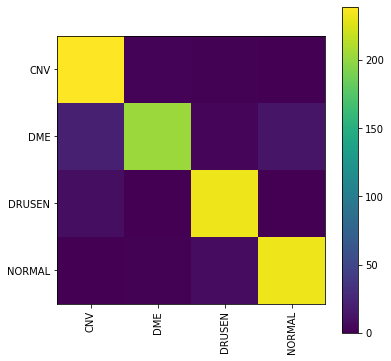

In [45]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [47]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.99      0.94       242
         DME       0.99      0.84      0.91       242
      DRUSEN       0.95      0.96      0.95       242
      NORMAL       0.94      0.96      0.95       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



**Testing on Images**

In [0]:
import os
from google.colab.patches import cv2_imshow

In [0]:
import tensorflow.keras.preprocessing.image as preimg

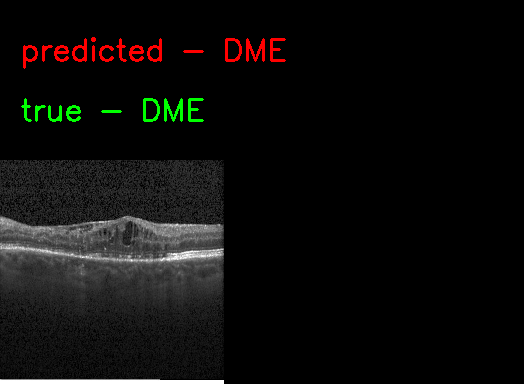

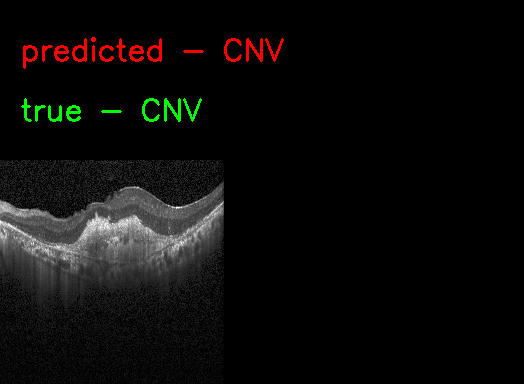

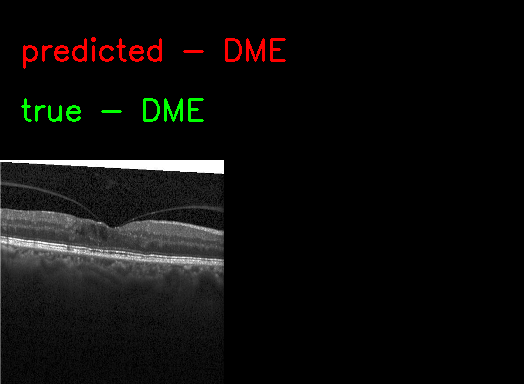

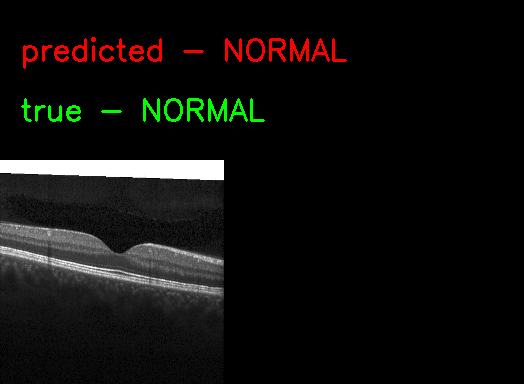

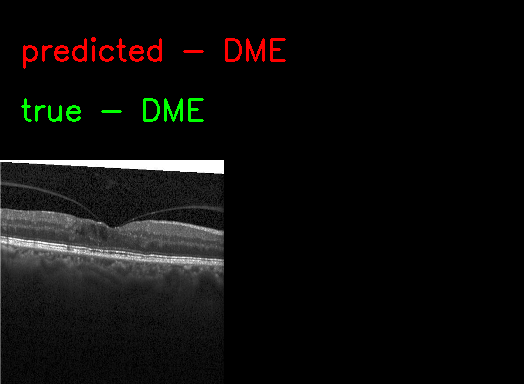

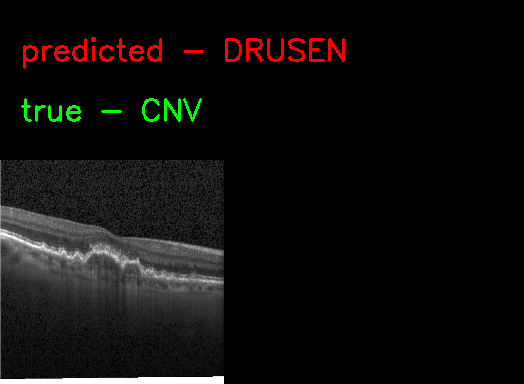

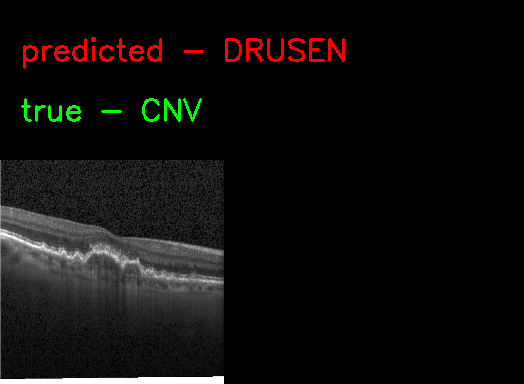

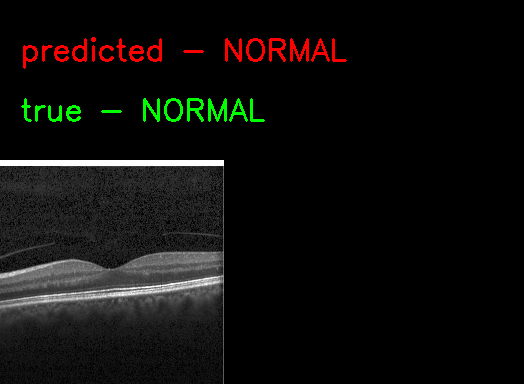

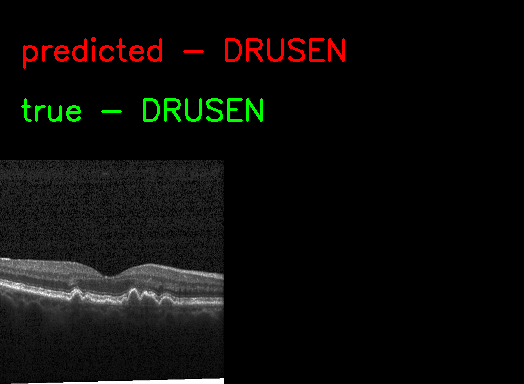

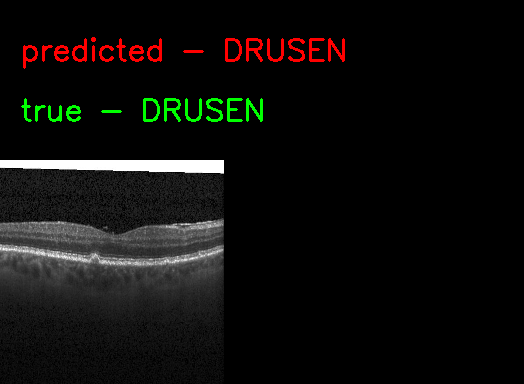

In [78]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2_imshow(expanded_image)
    

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return preimg.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'OCT2017 /val/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = preimg.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, (img_width, img_height), fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

**Plot the model structure**

In [0]:
from tensorflow.keras.utils import plot_model

(-0.5, 668.5, 1843.5, -0.5)

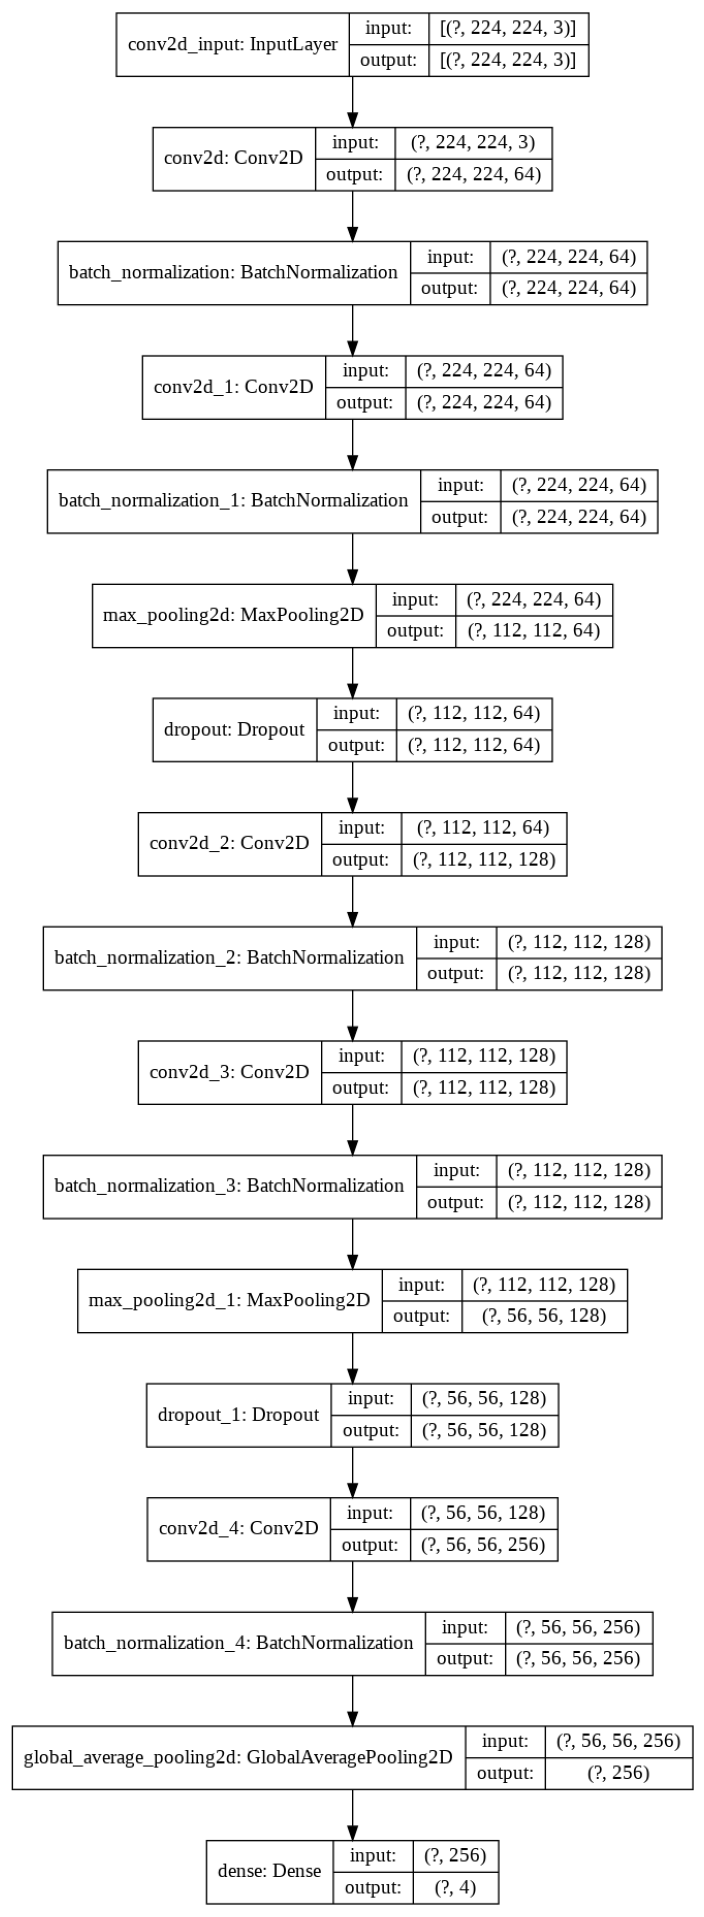

In [77]:
plot_model(model, to_file="model_plot_retinal_cnn5.png", show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_plot_retinal_cnn5.png')
plt.figure(figsize=(45,35))
plt.imshow(img)
plt.axis("off")